In [1]:
using NeutrinoTelescopes
using Flux
using ParameterSchedulers
using CUDA
using Random
using StaticArrays
using BSON: @save, @load
using BSON
using CairoMakie
using Rotations
using LinearAlgebra
using DataFrames
using Zygote
using PoissonRandom
using SpecialFunctions
using StatsBase
using Base.Iterators
using Distributions
using Optim
using LogExpFunctions
using Base.Iterators
using Formatting
using PhysicsTools
using PhotonPropagation
using Parquet

In [2]:
mutable struct ModelParam{T<:Number, LB<:Number, UB <:Number}
    name::String
    value::T
    active::Bool
    bounds::Tuple{LB, UB}
end

mutable struct Model
    params::Vector{ModelParam}
end

params(m::Model) = m.params
free_params(m::Model) = [p for p in params(m) if p.active]
get_lower_bounds(m::Model) = [p.bounds[1] for p in free_params(m)]
get_upper_bounds(m::Model) = [p.bounds[2] for p in free_params(m)]
get_seeds(m::Model) = [p.value for p in free_params(m)]

function get_param(m::Model, name::String)
    fp = nothing
    for p in params(m)
        if p.name == name
            fp = p
        end
    end

    if isnothing(fp)
        error("Parameter $name not found in model")
    end

    return fp
end

function set_inactive!(m::Model, name::String)
    p = get_param(m, name)
    p.active = false
end

function set_active!(m::Model, name::String)
    p = get_param(m, name)
    p.active = true
end

function parse_model_params(x, model)

    @assert length(x) == length(free_params(model))
    
    fix = 1
    mparams = params(model)

    parsed = []
    for par in mparams
        if mparams[fix].active
            val = x[fix]
            fix +=1
        else
            val = par.value
        end

        push!(parsed, val)
    end
    return parsed
end

function make_event_fit_model(;seed_log_energy=3., seed_zenith=0.5, seed_azimuth=0.5, seed_x=0., seed_y=0., seed_z=0., seed_time=0.)
    logenergy = ModelParam("logenergy", seed_log_energy, true, (2., 5.))
    zenith = ModelParam("zenith", seed_zenith, true, (0., π))
    
    azimuth = ModelParam("azimuth", seed_azimuth, true, (seed_azimuth-π, seed_azimuth+π))
    #azimuth = ModelParam("azimuth", seed_azimuth, true, (0., 2*π))
    pos_x = ModelParam("pos_x", seed_x, true, (-500., 500.))
    pos_y = ModelParam("pos_y", seed_y, true, (-500., 500.))
    pos_z = ModelParam("pos_z", seed_z, true, (-1000., 100.))
    time = ModelParam("time", seed_time, true, (-50., 100.))
    return Model([logenergy, zenith, azimuth, pos_x, pos_y, pos_z, time])
end

function _weights_per_module(targets, data)
    n_pmt = get_pmt_count(eltype(targets))
    @assert length(targets) * n_pmt == length(data) 

    weights = length.(data)
    weights_rs = reshape(weights, n_pmt, length(targets))
    weights_per_mod = sum(weights_rs, dims=1)[1, :]

    return weights_per_mod
end


function calc_center_of_mass(targets, data)
    weights_per_mod = _weights_per_module(targets, data)
    com = 1/sum(weights_per_mod) .* sum(weights_per_mod .* [t.position for t in targets])
    return com
end



function calculate_inertia_matrix(targets, data, com)
    com = calc_center_of_mass(targets, data)
    delta_r = [t.position .- com for t in targets]
    delta_r_ssc = ssc.(delta_r)
    
    weights_per_mod = _weights_per_module(targets, data)
    im = - sum(weights_per_mod .* delta_r_ssc.^2)

    return im
end

function calculate_inertia_matrix(targets, data)
    return calculate_inertia_matrix(target, data, calc_center_of_mass(target, data))
end




calculate_inertia_matrix (generic function with 2 methods)

In [3]:
function make_obj_func_cascade(fit_model; data, targets, model, tf_vec, c_n, use_feat_buffer=true)
    
    feat_buffer = use_feat_buffer ? zeros(9, get_pmt_count(eltype(targets))*length(targets)) : nothing

    function obj_func(x)
        logenergy, theta, phi, pos_x, pos_y, pos_z, time = parse_model_params(x, fit_model)
        fval =  -single_cascade_likelihood(logenergy, theta, phi, SA[pos_x, pos_y, pos_z], time; data=data, targets=targets, model=model, tf_vec=tf_vec, c_n=c_n, feat_buffer=feat_buffer)
        return fval
    end
    return obj_func
end

function make_obj_func_track(fit_model; data, losses, muon_energy, targets, model, tf_vec, c_n, use_feat_buffer=true)
    
    feat_buffer = use_feat_buffer ? zeros(9, get_pmt_count(eltype(targets))*length(targets)*length(losses)) : nothing

    function obj_func(x)
        logenergy, theta, phi, pos_x, pos_y, pos_z, time = parse_model_params(x, fit_model)
        fval = -track_likelihood_fixed_losses(logenergy, theta, phi, SA[pos_x, pos_y, pos_z], time; losses=losses_filt, muon_energy=muon_energy, data=data, targets=targets_range, model=model, tf_vec=tf_vec, c_n=c_n, feat_buffer=feat_buffer)
        return fval
    end
    return obj_func
end

function min_lh(fit_model, obj_func; strategy=:cg)
    lower = get_lower_bounds(fit_model)
    upper = get_upper_bounds(fit_model)
    seeds = get_seeds(fit_model)

    if strategy == :cg
        inner_optimizer = ConjugateGradient()
        algo = Fminbox(inner_optimizer) 
        results  = optimize(obj_func, lower, upper, seeds, algo; autodiff=:forward)
    elseif strategy == :annealing
        algo = SAMIN(rt=0.5)
        opt = Optim.Options(iterations=10^5)
        results  = optimize(obj_func, lower, upper, seeds, algo, opt)
    else
        error("Strategy $strategy unknown.")
    end
    
    return results
end


function calc_resolution_maxlh(targets, sampling_model, eval_model, n; energy=1E4, zenith=0.1, phi=0.1, position=SA[3., 10., 15.], time=0.)
    
    rng = MersenneTwister(31338)
    hypo = make_cascade_fit_model(seed_x=position[1], seed_y=position[2], seed_z=position[3], seed_time=time)
    set_inactive!(hypo, "pos_x")
    set_inactive!(hypo, "pos_y")
    set_inactive!(hypo, "pos_z")
    set_inactive!(hypo, "time")
    min_vals = []
    for _ in 1:n
        samples = sample_cascade_event(energy, zenith, phi, position, time; targets=targets, model=sampling_model[:model], tf_vec=sampling_model[:tf_dict], rng=rng)
        res = min_lh(hypo, samples, targets, eval_model[:model], eval_model[:tf_dict])    
        push!(min_vals, Optim.minimizer(res))
    end
    min_vals = reduce(hcat, min_vals)

    return min_vals
end

calc_resolution_maxlh(targets, model, n) = calc_resolution_maxlh(targets, model, model, n)



function mc_expectation(particles::AbstractVector{<:Particle}, targets::AbstractVector{<:D}, seed) where {T, N, L, D <: MultiPMTDetector{T, N, L}}
    
    wl_range = (300.0f0, 800.0f0)
    medium = make_cascadia_medium_properties(0.99f0)
    spectrum = CherenkovSpectrum(wl_range, medium)

    sources = [ExtendedCherenkovEmitter(convert(Particle{Float32}, p), medium, wl_range) for p in particles]

    targets_c::Vector{MultiPMTDetector{Float32, N, L}} = targets

    @show eltype(targets_c)

    photon_setup = PhotonPropSetup(sources, targets_c, medium, spectrum, seed)
    photons = propagate_photons(photon_setup)

    calc_total_weight!(photons, photon_setup)
    calc_time_residual!(photons, photon_setup)

    rot = RotMatrix3(I)
    hits = make_hits_from_photons(photons, photon_setup, rot)
    return hits
end


function compare_mc_model(
    particles::AbstractVector{<:Particle},
    targets::AbstractVector{<:PhotonTarget},
    models::Dict,
    medium::MediumProperties,
    hits)
    
    c_n = c_at_wl(800f0, medium)

   
    fig = Figure(resolution=(1500, 1000))
    ga = fig[1, 1] = GridLayout(4, 4)

    for i in 1:16
        row, col = divrem(i - 1, 4)
        mask = hits[:, :pmt_id] .== i
        ax = Axis(ga[col+1, row+1], xlabel="Time Residual(ns)", ylabel="Photons / time", title="PMT $i",
                  )
        hist!(ax, hits[mask, :tres], bins=-50:3:150, weights=hits[mask, :total_weight], color=:orange, normalization=:density,)
    end

    n_pmt = get_pmt_count(eltype(targets))

    t_geos = repeat([calc_tgeo(norm(particles[1].position - t.position) - t.radius, c_n) for t in targets], n_pmt)
    t0 = particles[1].time
    
    #=
    oversample = 500
    @load models["4"] model hparams opt tf_dict
    samples = sample_multi_particle_event(particles, targets, model, tf_dict, c_n, rng, oversample=oversample)
    tgeo = calc_tgeo(norm(particles[1].position - targets[1].position) - targets[1].radius, c_n)
    for i in 1:16
        row, col = divrem(i - 1, 4)
        hist!(ga[col+1, row+1], samples[i] .- tgeo .- t0 , bins=-50:3:150, normalization=:density, fillaplha=0.3, weights=fill(1/oversample, length(samples[i])))
    end
    =#

    times = -50:1:150
    for (mname, model_path) in models
        @load model_path model hparams opt tf_vec
        input = calc_flow_input(particles, targets, tf_vec)
        

        shape_lhs = []
        local log_expec
        for t in times
            _, shape_lh, log_expec = SurrogateModels.evaluate_model(particles, Vector.(eachrow(t .+ t_geos .+ t0)), targets, gpu(model), tf_vec, c_n)
            push!(shape_lhs, collect(shape_lh))
        end

        shape_lh = reduce(hcat, shape_lhs)

        for i in 1:16
            row, col = divrem(i - 1, 4)
            lines!(ga[col+1, row+1], times, exp.(shape_lh[i, :] .+ log_expec[i]), label=mname)
            
        end
    end

    fig
end

compare_mc_model(particles, targets, models) =  compare_mc_model(particles, targets, models, mc_expectation(particles, targets))

compare_mc_model (generic function with 2 methods)

# Setup
Load surrogate models and create a few detector configurations.

In [4]:
models = Dict(
    "1" => joinpath(@__DIR__, "../assets/full_kfold_1_FNL.bson"),
    "2" => joinpath(@__DIR__, "../assets/full_kfold_2_FNL.bson"),
    "3" => joinpath(@__DIR__, "../assets/full_kfold_3_FNL.bson"),
    "4" => joinpath(@__DIR__, "../assets/full_kfold_4_FNL.bson"),
    "5" => joinpath(@__DIR__, "../assets/full_kfold_5_FNL.bson"),
    #"FULL" => joinpath(@__DIR__, "../assets/rq_spline_model_l2_0_FULL_FNL.bson")
)
    
targets_single = [make_pone_module(@SVector[-25., 0., -450.], 1)]
targets_line = make_detector_line(@SVector[-25., 0.0, 0.0], 20, 50, 1)
targets_three_l = [
    make_detector_line(@SVector[-25., 0.0, 0.0], 20, 50, 1)
    make_detector_line(@SVector[25., 0.0, 0.0], 20, 50, 21)
    make_detector_line(@SVector[0., sqrt(50^2-25^2), 0.0], 20, 50, 41)]
targets_hex = make_hex_detector(3, 50, 20, 50, truncate=1)

detectors = Dict("Single" => targets_single, "Line" =>targets_line, "Tri" => targets_three_l, "Hex" => targets_hex)
medium = make_cascadia_medium_properties(0.99f0)


WaterProperties{Float32}(34.82f0, 265.91748f0, 1.8f0, 0.0075f0, 0.0075f0, 36.08f0, 1013.2627f0, 0.99f0, (1.3240297f0, 16.262556f0, -4382.0f0, 1.1455f6))

# Surrogate model
Verify that the surrogate model can reproduce MC.

Create a rather complicated (non-physical) event consisting of multiple extended cascades,
rund photon MC and compare the detected photons to the expectation from the surrogate model.

In [10]:
pos = SA[-25., 2., -460]
dir_theta = 0.7
dir_phi = 1.3
dir = sph_to_cart(dir_theta, dir_phi)
energy = 3e4

rng = MersenneTwister(31338)
particles = [
        Particle(SA[-23., -1., -450], dir, -10., 5., 0., PEMinus),
        Particle(pos, dir, 0., energy, 0., PEMinus),
        Particle(pos .+ dir.*5, dir, 15, energy, 0. ,PEMinus),
        Particle(pos .+ dir.*10, dir, 25, energy, 0. ,PEMinus)
]


hits = mc_expectation(particles, targets_single, 1);

eltype(targets_c) = MultiPMTDetector{Float32, 16, 32}


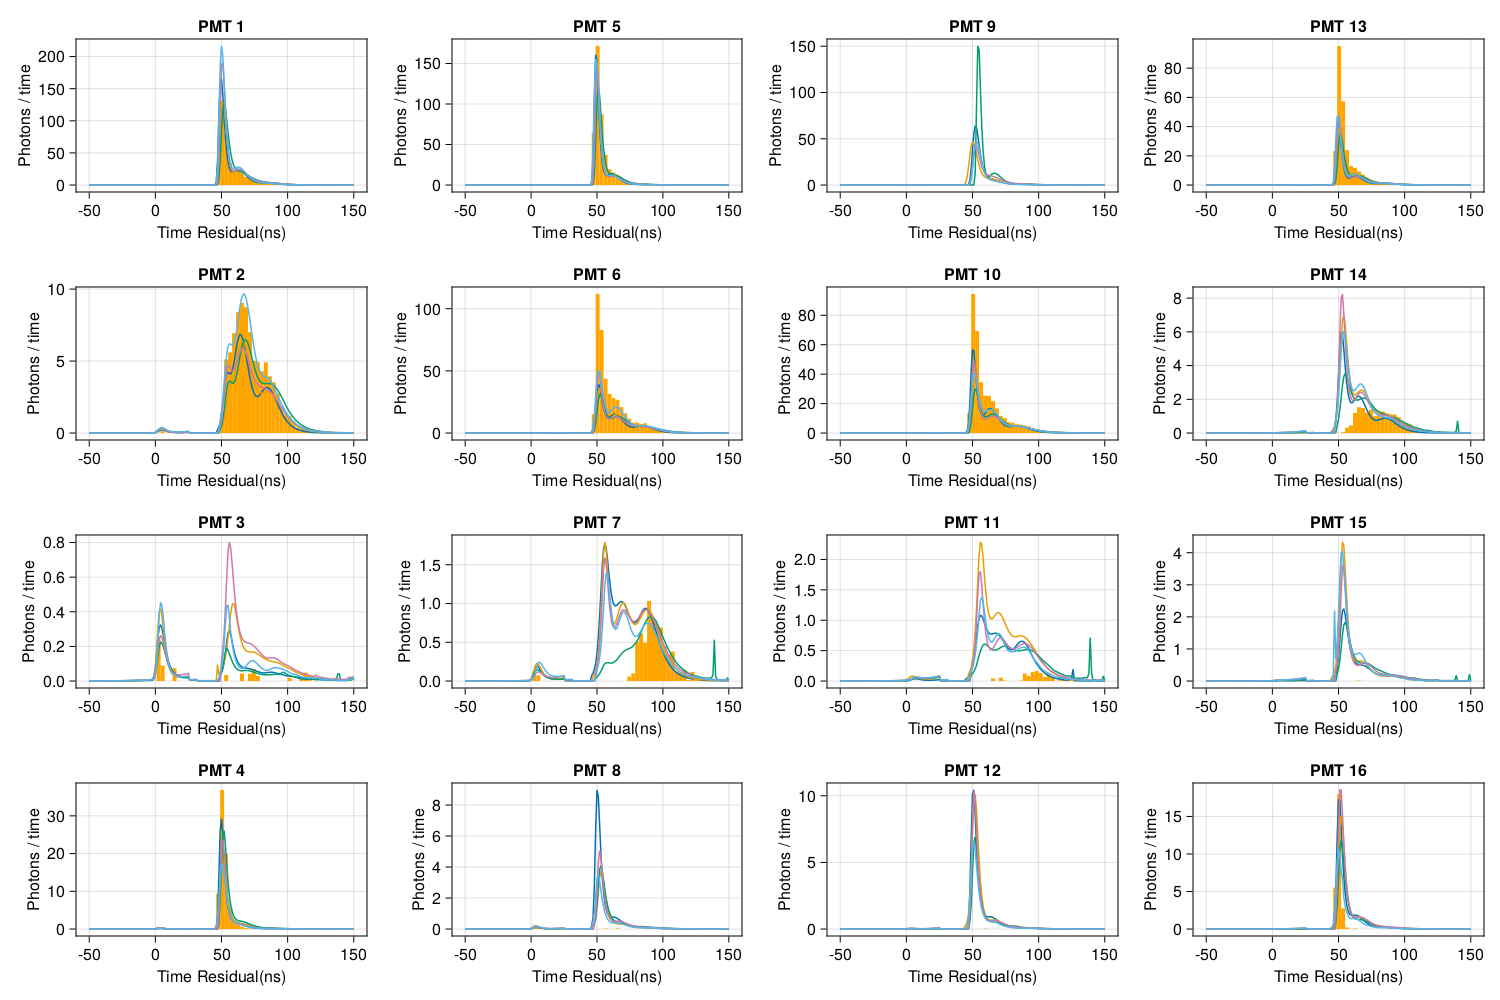

In [12]:
compare_mc_model(particles, targets_single, models, medium, hits)


## Save simulation

In [8]:
function hist_list_to_dataframe(hit_list, targets, target_mask)
    hits_nt = []
    n_pmt = get_pmt_count(eltype(targets))
    pmt_target_prod = product(1:n_pmt, targets[target_mask])

    for (hits, (pmt_id, target)) in zip(hit_list, pmt_target_prod)
        for hit in hits
            nt = (time=hit, pmt_id=pmt_id, module_id=Int(target.module_id))
            push!(hits_nt, nt)
        end
    end

    return DataFrame(hits_nt)

end


function targets_to_dataframe(targets)

    targets_nt = []

    for target in targets
        for (pmt_id, pmt_coords) in enumerate(eachcol(target.pmt_coordinates))
            nt = (
                module_id=Int(target.module_id),
                pmt_id=pmt_id,
                module_x=target.position[1],
                module_y=target.position[2],
                module_z=target.position[3],
                pmt_theta = pmt_coords[1],
                pmt_phi = pmt_coords[2]
            )
            push!(targets_nt, nt)
        end
    end

    return DataFrame(targets_nt)
end

function event_info_to_dataframe(particle)

    nt = (
        x=particle.position[1],
        y=particle.position[2],
        z=particle.position[3],
        dir_x=particle.direction[1],
        dir_y=particle.direction[2],
        dir_z=particle.direction[3],
        time=particle.time,
        energy=particle.energy,
        length=particle.length)

    return DataFrame([nt])
end


event_info_to_dataframe (generic function with 1 method)

In [9]:
@load models["4"] model hparams opt tf_dict

gpu_model = gpu(model)

pos = SA[8., -5., -450]
theta = 0.5
phi = 0.4
rng = MersenneTwister(31338)
energy = 9E4

particle = Particle(pos, sph_to_cart(theta, phi), 0., energy, 0., PEMinus)


target_mask = [norm(t.position .- pos) < 200 for t in targets_hex]
targets_range = targets_hex[target_mask]

c_n = c_at_wl(800f0, medium)
samples = sample_cascade_event(energy, theta, phi, pos, 0.; targets=targets_range, model=model, tf_vec=tf_dict, rng=rng, c_n=c_n)

samples_df = hist_list_to_dataframe(samples, targets_hex, target_mask)
targets_df = targets_to_dataframe(targets_hex)
event_df = event_info_to_dataframe(particle)
write_parquet(joinpath(@__DIR__, "../data/cascade_hits.parquet"), samples_df)
write_parquet(joinpath(@__DIR__, "../data/cascade_geometry.parquet"), targets_df)
write_parquet(joinpath(@__DIR__, "../data/cascade_mctruth.parquet"), event_df)


4

# Likelihood
## Plots of likelihood scans for an example event.

Simulate an event for the different detector configs and plot 1D likelihood scans in energy, zenith and azimuth

In [11]:
@load models["4"] model hparams opt tf_dict

gpu_model = gpu(model)

pos = SA[8., -5., -450]
theta = 0.5
phi = 0.4
rng = MersenneTwister(31338)
targets_range = [t for t in targets_hex if norm(t.position .- pos) < 200]

c_n = c_at_wl(800f0, medium)

samples = sample_cascade_event(5E4, theta, phi, pos, 0.; targets=targets_range, model=model, tf_vec=tf_dict, rng=rng, c_n=c_n)

pos_seed = calc_center_of_mass(targets_range, samples)

hypo = make_event_fit_model(seed_x=pos_seed[1], seed_y=pos_seed[2], seed_z=pos_seed[3], seed_time=0.)#seed_x=pos[1], seed_y=pos[2], seed_z=pos[3], seed_time=0.)
# Fix time
set_inactive!(hypo, "time")

obj_func = make_obj_func_cascade(hypo; data=samples, targets=targets_range, model=gpu_model, tf_vec=tf_dict, c_n=c_n, use_feat_buffer=false)
res = min_lh(hypo, obj_func, strategy=:cg)

# Maximum likelihood
bestfit = Optim.minimizer(res)

6-element Vector{Float64}:
    4.690380675521738
    3.126410114439346
    0.7408425772484014
    9.737336250716933
   -4.210511607815243
 -442.24207717395456

In [13]:
fig = Figure(resolution=(1000, 1000))

for (i, (key, targ)) in enumerate(detectors)

    targets_range = [t for t in targ if norm(t.position .- pos) < 200]
    samples = sample_cascade_event(5E4, theta, phi, pos, 0.; targets=targets_range, model=model, tf_vec=tf_dict, rng=rng, c_n=c_n)
    hypo = make_cascade_fit_model(seed_x=pos[1], seed_y=pos[2], seed_z=pos[3], seed_time=0.)
    res = min_lh(hypo, samples, targets_range, model, tf_dict, c_n)
    minvals = Optim.minimizer(res)


    ax1 = Axis(fig[i, 1])
    llhs = [single_cascade_likelihood(le, theta, phi, pos, 0.; samples=samples, targets=targets_range, model=model, tf_vec=tf_dict, c_n=c_n) for le in les]
    lines!(ax1, les, llhs)
    vlines!(ax1, [log10(5E4), minvals[1]], color=[:red, :black])


    ax2 = Axis(fig[i, 2])
    llhs = [single_cascade_likelihood(log10(5E4), zen, phi, pos, 0.; samples=samples, targets=targets_range, model=model, tf_vec=tf_dict, c_n=c_n) for zen in zens]
    lines!(ax2, zens, llhs)
    vlines!(ax2, [theta, minvals[2]], color=[:red, :black])

    ax3 = Axis(fig[i, 3])
    llhs = [single_cascade_likelihood(log10(5E4), theta, azi, pos, 0.; samples=samples, targets=targets_range, model=model, tf_vec=tf_dict, c_n=c_n) for azi in azis]
    lines!(ax3, azis, llhs)
    vlines!(ax3, [phi, minvals[3]], color=[:red, :black])
end

fig

UndefVarError: UndefVarError: make_cascade_fit_model not defined

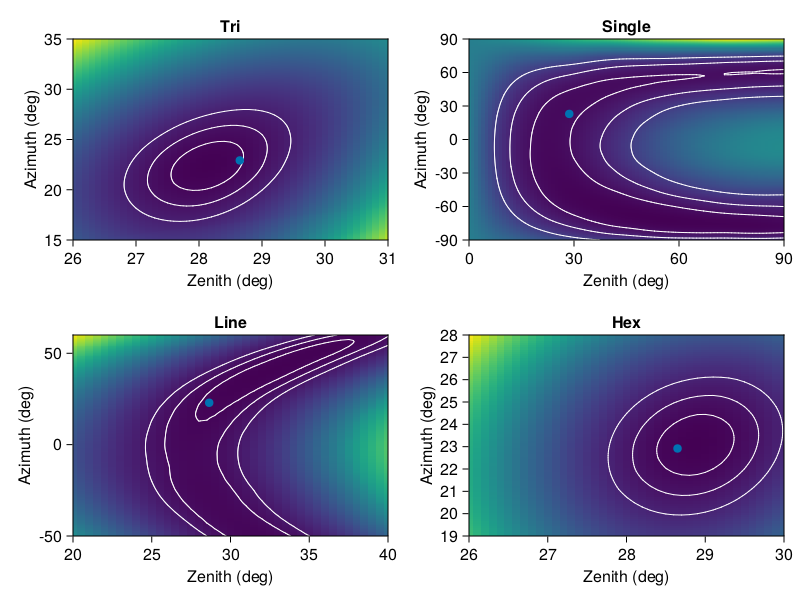

In [14]:
pos = SA[8., -5., -450]
theta = 0.5
phi = 0.4
rng = MersenneTwister(31338)
#targets_range = [target]

axis_ranges = Dict("Tri" => (26, 31, 15, 35, 0.1), "Single" => (0, 90, -90, 90, 1), "Line" => (20, 40, -50, 60, 0.5), "Hex" => (26, 30, 19, 28, 0.1))

levels = map(sigma -> invlogcdf(Chisq(2), log(1-2*ccdf(Normal(), sigma))), [1, 2, 3])


fig = Figure()
ga = fig[1, 1] = GridLayout()

for (i, (dkey, targets)) in enumerate(detectors)

    ranges = axis_ranges[dkey]
    thetas = deg2rad.(ranges[1]:ranges[end]:ranges[2])
    phis = deg2rad.(ranges[3]:ranges[end]:ranges[4])


    targets_range = [t for t in targets if norm(t.position .- pos) < 200]
    data = sample_cascade_event(5E4, theta, phi, pos, 0.; targets=targets_range, model=model, tf_vec=tf_dict, rng=rng, c_n=c_n)
    
    llh2d = single_cascade_likelihood.(log10(5E4), thetas, permutedims(phis), Ref(pos), 0.; data=data, targets=targets_range, model=gpu(model), tf_vec=tf_dict, c_n=c_n)
    rellh = maximum(llh2d) .- llh2d
    row, col = divrem(i-1, 2)
    ax = Axis(ga[row+1, col+1], title=dkey, xlabel="Zenith (deg)", ylabel="Azimuth (deg)", limits=ranges[1:4])
    hm = heatmap!(ax, rad2deg.(thetas), rad2deg.(phis), rellh)
    contour!(ax,  rad2deg.(thetas), rad2deg.(phis), rellh, levels=levels, color=:white)
    scatter!(ax, rad2deg(theta), rad2deg(phi))
end
#Colorbar(fig[1, 2], hm)
fig

# Mock Muon

In [15]:
function create_mock_muon(energy, position, direction, time, mean_free_path, length, rng)
    losses = []

    step_dist = Exponential(mean_free_path)
    eloss_logr_dist = Uniform(-5, 0)

    dist_travelled = 0
    while dist_travelled < length && energy > 1
        step_size = rand(rng, step_dist)
        e_loss = energy * 10^rand(rng, eloss_logr_dist)

        energy -= e_loss
        dist_travelled += step_size
        pos = position .+ dist_travelled .* direction
        t = time + dist_travelled * 0.3

        push!(losses, Particle(pos, direction, t, e_loss, 0., PEMinus))
    
    end

    return losses
end

create_mock_muon (generic function with 1 method)

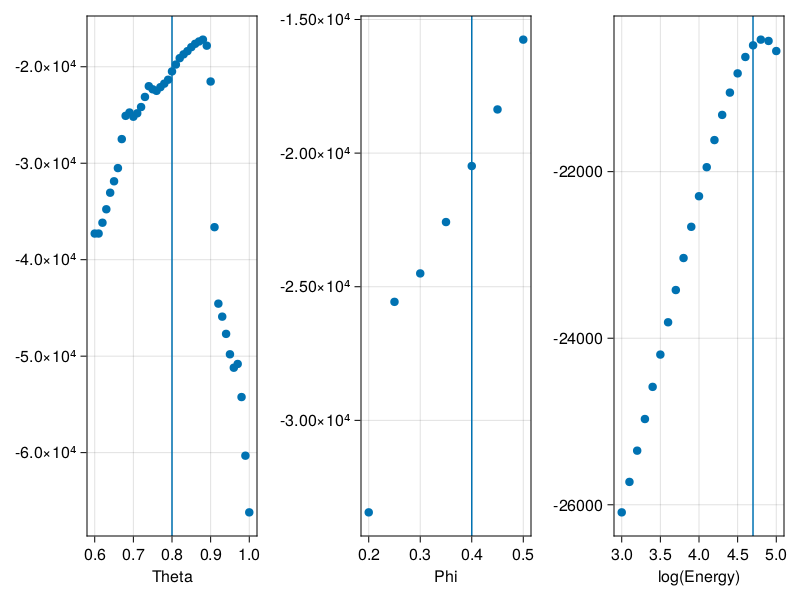

In [16]:
p0 = SA[8., -5., -450]

theta = 0.8
phi = 0.4
muon_energy = 5E4
rng = MersenneTwister(3)
dir = sph_to_cart(theta, phi)
pos = p0 .- 200 .* dir 

losses = create_mock_muon(muon_energy, pos, dir, 0., 30, 500, rng)
losses_filt = [p for p in losses if p.energy > 100]

@load models["4"] model hparams opt tf_dict
c_n = c_at_wl(800f0, medium)
target_mask = any(norm.([p.position for p in losses_filt] .- permutedims([t.position for t in targets_hex])) .<= 200, dims=1)[1, :]
targets_range = targets_hex[target_mask]

feat_buffer = zeros(9, get_pmt_count(eltype(targets_range))*length(targets_range)*length(losses_filt))


data = sample_multi_particle_event(losses_filt, targets_range, model, tf_dict, c_n, rng)


fig = Figure()
ax1 = Axis(fig[1, 1], xlabel="Theta")

thetas = 0.6:0.01:1
llhs = [track_likelihood_fixed_losses(log10(muon_energy), t, phi, pos, 0.; losses=losses_filt, muon_energy=muon_energy, data=data, targets=targets_range, model=gpu(model), tf_vec=tf_dict, c_n=c_n, feat_buffer=feat_buffer) for t in thetas]
scatter!(ax1, thetas, llhs)
vlines!(ax1, theta)
ax2 = Axis(fig[1, 2], xlabel="Phi")

phis = 0.2:0.05:0.5
llhs = [track_likelihood_fixed_losses(log10(muon_energy), theta, p, pos, 0.; losses=losses_filt, muon_energy=muon_energy, data=data, targets=targets_range, model=gpu(model), tf_vec=tf_dict, c_n=c_n, feat_buffer=feat_buffer) for p in phis]
scatter!(ax2, phis, llhs)
vlines!(ax2, phi)


ax3 = Axis(fig[1, 3], xlabel="log(Energy)")
logenergies = 3:0.1:5
llhs = [track_likelihood_fixed_losses(le, theta, phi, pos, 0.; losses=losses_filt, muon_energy=muon_energy, data=data, targets=targets_range, model=gpu(model), tf_vec=tf_dict, c_n=c_n, feat_buffer=feat_buffer) for le in logenergies]
scatter!(ax3, logenergies, llhs)
vlines!(ax3, log10(muon_energy))
fig

In [11]:
hypo = make_event_fit_model(seed_x=pos[1], seed_y=pos[2], seed_z=pos[3], seed_time=0.)#seed_x=pos[1], seed_y=pos[2], seed_z=pos[3], seed_time=0.)
set_inactive!(hypo, "time")
obj_func = make_obj_func_track(hypo; data=data, losses=losses_filt, muon_energy=muon_energy, targets=targets_range, model=model, tf_vec=tf_dict, c_n=c_n)
res = min_lh(hypo, obj_func, strategy=:cg)
Optim.minimizer(res)

 * Status: success

 * Candidate solution
    Final objective value:     2.665301e+03

 * Found with
    Algorithm:     Fminbox with Conjugate Gradient

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.75e+01 ≰ 1.0e-08

 * Work counters
    Seconds run:   282  (vs limit Inf)
    Iterations:    2
    f(x) calls:    172
    ∇f(x) calls:   165


# FIX EVALUATION RANGE

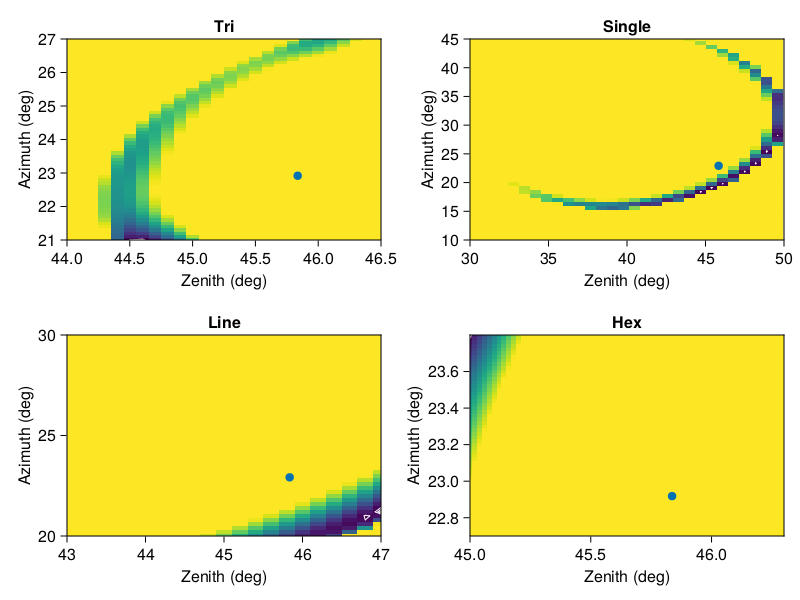

In [17]:
p0 = SA[8., -5., -450]

theta = 0.8
phi = 0.4
muon_energy = 5E4
rng = MersenneTwister(4)
dir = sph_to_cart(theta, phi)
pos = p0 .- 200 .* dir 

losses = create_mock_muon(muon_energy, pos, dir, 0., 30, 500, rng)
losses_filt = [p for p in losses if p.energy > 100]

@load models["4"] model hparams opt tf_dict
c_n = c_at_wl(800f0, medium)

axis_ranges = Dict("Tri" => (44, 46.5, 21, 27, 0.1), "Single" => (30, 50, 10, 45, 0.7), "Line" => (43, 47, 20, 30, 0.2), "Hex" =>  (45, 46.3, 22.7, 23.8, 0.02))

levels = map(sigma -> invlogcdf(Chisq(2), log(1-2*ccdf(Normal(), sigma))), [1, 2, 3])


fig = Figure()
ga = fig[1, 1] = GridLayout()

for (i, (dkey, targets)) in enumerate(detectors)

    ranges = axis_ranges[dkey]
    thetas = deg2rad.(ranges[1]:ranges[end]:ranges[2])
    phis = deg2rad.(ranges[3]:ranges[end]:ranges[4])

    target_mask = any(norm.([p.position for p in losses_filt] .- permutedims([t.position for t in targets])) .<= 100, dims=1)[1, :]

    if !any(target_mask)
        continue
    end

    targets_range = targets[target_mask]
    data = sample_multi_particle_event(losses_filt, targets_range, model, tf_dict, c_n, rng)
    
    feat_buffer = zeros(9, get_pmt_count(eltype(targets_range))*length(targets_range)*length(losses_filt))

    llh2d = track_likelihood_fixed_losses.(log10(muon_energy), thetas, permutedims(phis), Ref(pos), 0.; muon_energy=muon_energy, losses=losses_filt, data=data, targets=targets_range, model=gpu(model), tf_vec=tf_dict, c_n=c_n, feat_buffer=feat_buffer)
    rellh = maximum(llh2d) .- llh2d
    row, col = divrem(i-1, 2)
    ax = Axis(ga[row+1, col+1], title=dkey, xlabel="Zenith (deg)", ylabel="Azimuth (deg)", limits=ranges[1:4])
    hm = heatmap!(ax, rad2deg.(thetas), rad2deg.(phis), rellh, colorrange=(0, 500))
    contour!(ax,  rad2deg.(thetas), rad2deg.(phis), rellh, levels=levels, color=:white)
    scatter!(ax, rad2deg(theta), rad2deg(phi))
end
#Colorbar(fig[1, 2], hm)
fig

In [9]:


Flux.testmode!(model)

pos = SA[-10., 5., 10.]
targets_range = [t for t in targets if norm(t.position .- pos) < 200]
targets_range = [target]




samples = sample_cascade_event(5E4, 0.2, 0.1, pos, 0.; targets=targets_range, model=model, tf_vec=tf_dict, rng=Random.GLOBAL_RNG)
hypo = make_cascade_fit_model(seed_x=-10., seed_y=10., seed_z=10., seed_time=0.)





res = min_lh(hypo, samples, targets_range, model, tf_dict)
minvals = Optim.minimizer(res)



UndefVarError: UndefVarError: model not defined

In [46]:
targets_range = [t for t in targets if norm(t.position .- pos) < 200]
model_res = Dict()
for (mname, model_path) in models
    m = BSON.load(model_path)
    Flux.testmode!(m[:model])
    res = calc_resolution_maxlh(targets_range, m, 200)
    model_res[mname] = res
end

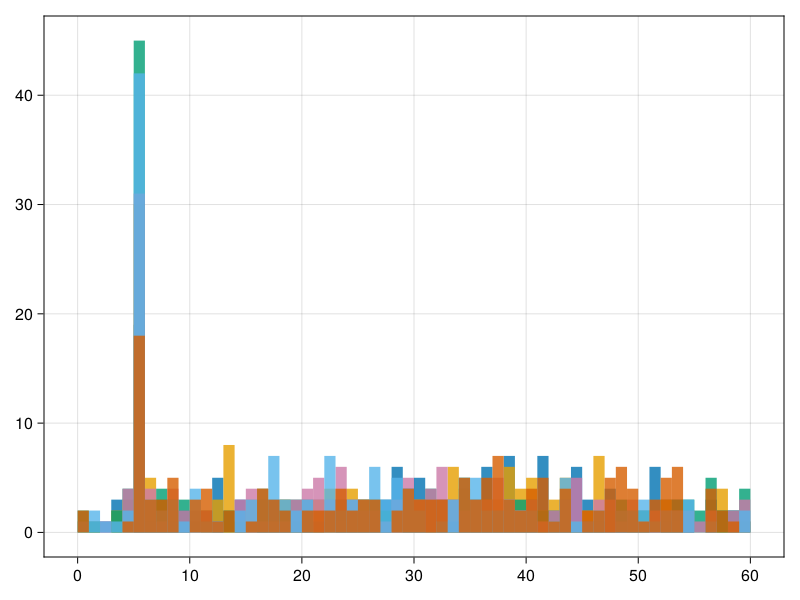

In [48]:
fig = Figure()
ax = Axis(fig[1, 1])

bins = 0:1:60

for (k, v) in model_res

    hist!(ax, rad2deg.(acos.(dot.(sph_to_cart.(v[2, :], v[3, :]), Ref(sph_to_cart(0.1, 0.1))))),
    label=k, bins=bins)

end
fig